In [3]:
from __future__ import division, absolute_import, print_function
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

### Extract basis of trends from Kepler Q14 (DR25) CBV file

In [4]:
J = 24   # number of cameras
N = 4    # number of trends per camera
K = 1000 # number of observations
T_true = np.ones((J,K,N)) # basis matrix - allow for 1 bias term per camera
t = np.arange(K)

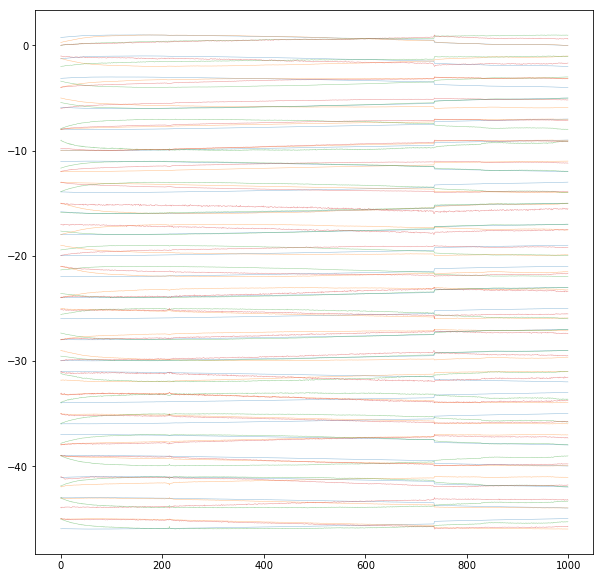

In [5]:
from astropy.io import fits as pf
hdul = pf.open('kplr2012277125453-q14-d25_lcbv.fits')
J_Kep = len(hdul)-1
j = 0
plt.figure(figsize=(10,10))
for jk in range(J_Kep):
    d = hdul[jk+1].data
    if len(d['VECTOR_1']) == 0: # empty MODOUT
        continue
    l = np.where(d['GAPFLAG'] == 0)[0][:K]
    for n in range(N):
        v = d['VECTOR_{}'.format(n+1)][l]
        vmin, vmax = np.nanmin(v), np.nanmax(v)
        v = (v-vmin) / (vmax-vmin)
        T_true[j,:,n] = v
        plt.plot(t,T_true[j,:,n]-2*j,'C{}-'.format(n),lw=0.5,alpha=0.5)
    j += 1
    if j == J: # that's enough
        break
hdul.close()

### Simulate stellar light curve (using QP GP)

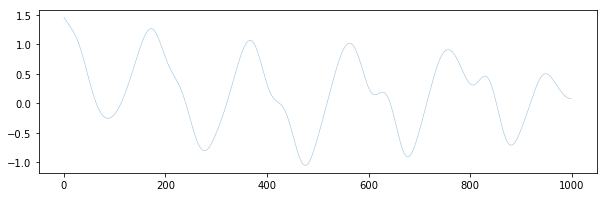

In [6]:
from george import kernels, GP
Period = 200
evol = 500
Gamma = 1.0
k = 1.0 * kernels.ExpSine2Kernel(gamma=Gamma,log_period=np.log(Period)) * \
    kernels.ExpSquaredKernel(metric=evol**2)
gp = GP(k)
A_true = gp.sample(t)
plt.figure(figsize=(10,3))
plt.plot(t,A_true,lw=0.5,alpha=0.5)

### Add transits

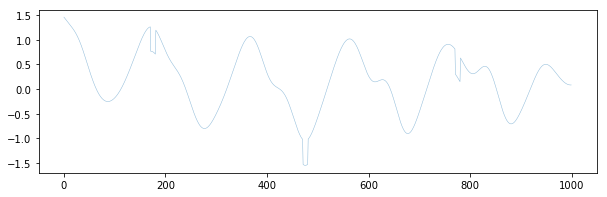

In [7]:
ptr = 300
t0tr = 175
dutr = 10
detr = 0.5
phtr = ((t-t0tr)%ptr)/ptr
phtr[phtr>0.5] -= 1
l = abs(phtr) <= (dutr/ptr/2)
A_true[l] -= detr
plt.figure(figsize=(10,3))
plt.plot(t,A_true,lw=0.5,alpha=0.5)

### Contruct J realisations of the light curve 
with different systematrics, white noise, and biases

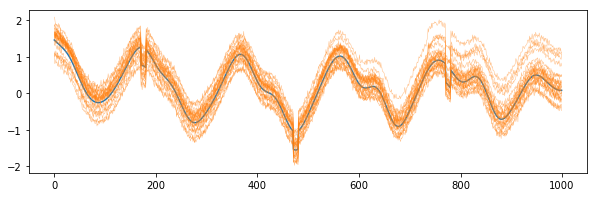

In [72]:
w_true = np.random.uniform(low=-0.5,high=0.5,size=(J,N))
sig = 0.05
F = np.zeros((J,K))
plt.figure(figsize=(10,3))
plt.plot(t,A_true,'C0-')
for j in range(J):
    F[j,:] = A_true + np.random.normal(scale=sig,size=K)
    for n in range(N):
        #print(j,n,W[j,n],np.nanmin(B[:,j,n]),np.nanmax(B[:,j,n]))
        F[j,:] += w_true[j,n] * T_true[j,:,n]
    plt.plot(t,F[j,:],'C1-',lw=0.5,alpha=.5)


### Solve for coefficients of the basis vectors

In [115]:
def construct_matrices(F, T, sigma):
    J, K = F.shape # F = observed fluxes, J = no. cameras, K = no. observations
    J1, K1, N = T.shape # T = common mode trends, N = no. trends (per camera)
    J2, K2 = sigma.shape # sigma = flux uncertainties
    assert J2 == J1 == J
    assert K2 == K1 == K
    M = J * N
    w = 1. / sigma**2
    Fw = F * w 
    Cinv = np.diag(1./w.sum(axis=0))
    D = np.zeros((K,M))
    E = np.zeros((M,M))
    for j in range(J):
        for n1 in range(N): 
            m1 = j * N + n1
            for k in range(K):
                D[k,m1] = T[j,k,n1] / sigma[j,k]**2
            for n2 in range(N):
                m2 = j * N + n2 
                E[m1, m2] = T[j,k,n1] * T[j,k,n2] * w[j,k]
    y = np.zeros(M+K)
    y[:K] = Fw.sum(axis=0)
    for j in range(J):
        FwT = Fw[:,j][:,None] * T[:,j,:]
        y[K+j*N:K+(j+1)*N] = FwT.sum(axis=0)
    return Cinv, D, E, y

In [116]:
from scipy.linalg import inv
def solve(F, T, sigma):
    J, K = F.shape # F = observed fluxes, J = no. cameras, K = no. observations
    J1, K1, N = T.shape # T = common mode trends, N = no. trends (per camera)
    J2, K2 = sigma.shape # sigma = flux uncertainties
    assert J2 == J1 == J
    assert K2 == K1 == K
    Cinv, D, E, y = construct_matrices(F, T, sigma)
    CinvD = np.dot(Cinv, D)
    DTCinvD = np.dot(D.T, CinvD)
    E_DTCinvD = E - DTCinvD
    E_DTCinvD_inv = inv(E_DTCinvD)
    bottomright = E_DTCinvD_inv
    topright = - np.dot(Cinv,np.dot(D,E_DTCinvD_inv))
    bottomleft = topright.T
    topleft = Cinv + np.dot(CinvD, -bottomleft)
    Xinv = np.zeros((K+J*N,K+J*N))
    Xinv[:K,:K] = topleft
    Xinv[:K,K:] = topright
    Xinv[K:,:K] = bottomleft
    Xinv[K:,K:] = bottomright
    p = np.dot(Xinv,y)
    J, K, N = T.shape
    a = p[:K]
    w = p[K:].reshape((J,N))
    B = np.zeros((J,K))
    for j in range(J):
        for n in range(N):
            B[j,:] += w[j,n] * T[j,:,n]
    return a, w, B

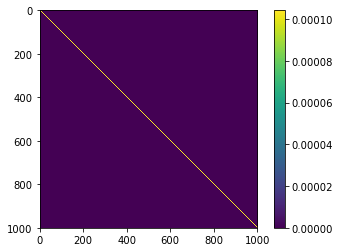

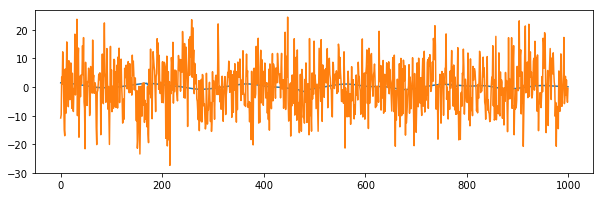

In [117]:
sigma = np.zeros((J,K)) + sig
a, w, B = solve(F, T_true, sigma)
plt.figure(figsize=(10,3))
plt.plot(t,A_true,'C0-')
plt.plot(t,a,'C1-')